In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os as so
import numpy as ny
from os import path
import pandas as ps
import pathlib as pb
from typing import List
import matplotlib.pyplot as pt
from modules import processing as pg
from numpy.random import default_rng


# Configure the paths to the data files
ROOT_PATH = pb.Path('..')
DATASET_PATH = pb.Path(path.join(ROOT_PATH, 'data'))
DATASET_TEST_PATH = pb.Path(path.join(DATASET_PATH, 'test'))
DATASET_TRAIN_PATH = pb.Path(path.join(DATASET_PATH, 'train'))
SUBMISSIONS_PATH = pb.Path(path.join(ROOT_PATH, 'submissions'))
DATASET_TRAIN_LABELS_FILEPATH = pb.Path(path.join(DATASET_PATH, 'train_labels.csv'))

# Use GPU if available
so.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import tensorflow as tw

# Show warning if running on CPU
available_devices = list(map(lambda d: d.device_type, tw.config.list_physical_devices()))
print('Available devices = ', tw.config.list_physical_devices())

if 'GPU' not in available_devices:
  print('Warning: running on CPU only')

2022-11-28 03:31:53.907978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 03:31:53.968116: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 03:31:54.291442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/lib64:
2022-11-28 03:31:54.291474: W tensorflow/compiler/x

Available devices =  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-28 03:31:54.626218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 03:31:54.630227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 03:31:54.630325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Number of training samples:  9000
Shape of a training sample:  (150, 3)
Number of testing samples:  5000
Shape of a testing sample:  (150, 3)


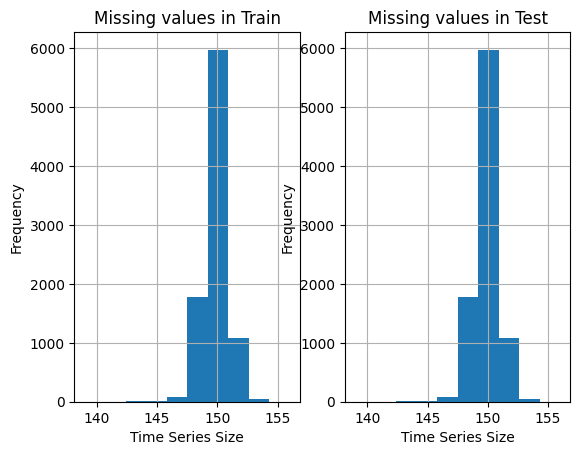

In [4]:
# Load the data from disk
dataset = pg.Dataset(DATASET_PATH)

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in dataset.train_data]
test_sizes = [sample.shape[0] for sample in dataset.train_data]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Missing values in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

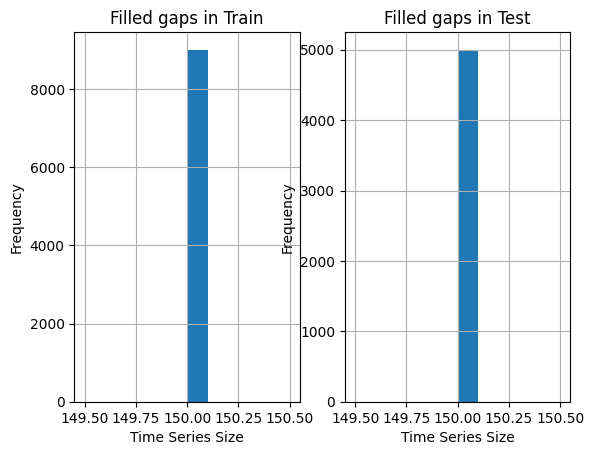

In [5]:
# Fill holes using interpolation
dataset.fill_gaps()

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in dataset.train_data]
test_sizes = [sample.shape[0] for sample in dataset.test_data]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Filled gaps in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

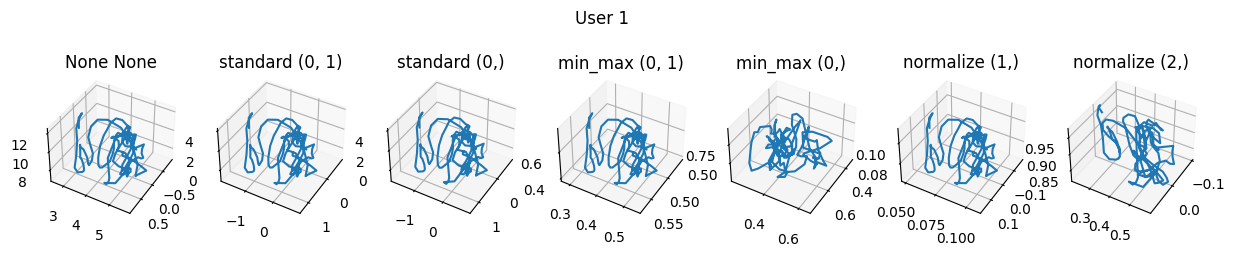

In [6]:
from numpy.random import default_rng
import copy

# Sample three recordings
gen = default_rng(24)
sample_i = gen.choice(9000, size=1, replace=False)

# Try different normalization / feature scaling methods
strategies = (
  (None, None),         # => no operation is applied    => -
  ('standard', (0, 1)), # => for each coordiante        => 3
  ('standard', (0,)),   # => temporal * each coordiante => 150 x 3
  ('min_max', (0, 1)),  # => for each coordiante        => 3
  ('min_max', (0,)),    # => temporal * each coordiante => 150 x 3
  ('normalize', (1,)),  # => norm of each coordinate    => 9000 x 3
  ('normalize', (2,)),  # => norm of each time moment   => 9000 x 150
)

# Display a sample in both sensor space and normalized space
f = pt.figure(figsize=(15, 5))
f.suptitle(f'User {i}')
for i, (strategy, axis) in enumerate(strategies):
  # Normalize copy to view different perspectives
  dataset_copy = copy.deepcopy(dataset)
  dataset_copy.normalize(strategy, axis)

  # Retrieve normalized samples
  record_x = dataset_copy.train_data[sample_i][0]

  # Display scaled vectors
  plot_n = f.add_subplot(2, len(strategies), i + 1, projection='3d')
  plot_n.plot(record_x[:, 0], record_x[:, 1], record_x[:, 2])
  plot_n.set_title(f'{strategy} {axis}')
  plot_n.view_init(elev=40, azim=30)
  del dataset_copy
pt.show()

In [7]:
# Standardize the training & testing data
dataset.normalize('standard', (0,))

# Reshape to (n_samples, n_features) commonly used format
dataset.reshape((-1, 450))

In [9]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from modules import models

# Display periodic plots across each fold
pt.figure()

# Configure kfold loop
tparams: models.TrainParams = {
  'n_folds': 5,
}

# Model providers / factories
model_cnn_factory = lambda: models.TCNNModel({
  'optim': lambda: Adam(learning_rate=2e-4, weight_decay=9e-6),
  'm_init': tw.keras.initializers.GlorotNormal(seed=24),
  'activ_fn': tw.keras.layers.Activation('relu'),
  'lr_update': (30, 10, 0.8),
  'n_filters': 64,
  's_filters': 7,
  'n_units': 724,
  'dropout': 0.3,
  'n_epochs': 150,
  'n_batch': 64,
}, ROOT_PATH)

model_factory = model_cnn_factory

# Train and validate using crossvalidation technique
trn_accy, val_accy = [], []
for i, (fold_train, fold_valid) in enumerate(KFold(shuffle=True, n_splits=tparams['n_folds']).split(dataset.train_data, dataset.train_labels)):
  # Create new model with random weights
  model = model_factory()

  # Gather points for each step
  train_samples_fold = dataset.train_data[fold_train.tolist()]
  valid_samples_fold = dataset.train_data[fold_valid.tolist()]
  train_labels_fold = dataset.train_labels[fold_train.tolist()]
  valid_labels_fold = dataset.train_labels[fold_valid.tolist()]

  # Learn on training data and predict on valid set
  history = model.fit(train_samples_fold, train_labels_fold, \
                      valid_samples_fold, valid_labels_fold)

  # Save max valid & train accy for the current fold
  val_accy.append(history.accuracy[1])
  trn_accy.append(history.accuracy[0])

  # Display fold results
  history.show()

# Show results across all folds
pt.show()
pt.figure()
print(f'mean_val_accy = {ny.mean(val_accy)}')
print(f'mean_trn_accy = {ny.mean(trn_accy)}')

# Show val across folds
pt.subplot(1, 2, 1)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Validation Accuracy')
pt.plot(ny.arange(tparams['n_folds']), val_accy)

# Show train across folds
pt.subplot(1, 2, 2)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Training Accuracy')
pt.plot(ny.arange(tparams['n_folds']), trn_accy)
pt.show()

2022-11-28 03:32:16.059944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 03:32:16.060794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 03:32:16.060938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 03:32:16.061024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/150


2022-11-28 03:32:17.933523: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-11-28 03:32:18.525849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-28 03:32:18.969402: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-28 03:32:18.970980: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2022-11-28 03:32:18.970994: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at /usr/local/cuda-11.2/bin/ptxas
2022-11-28 03:32:18.971072: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: /usr/local/cuda-11.2/bin/ptxas ptxas too old. Fa

113/113 [==============================] - 7s 16ms/step - loss: 1.7426 - categorical_accuracy: 0.4301 - gpu_id: 0/utilization.memory (%): 19.4513 - gpu_id: 0/utilization.gpu (%): 46.4513 - gpu_id: 0/memory.used (MiB): 23581.6482 - gpu_id: 0/memory.free (MiB): 640.1643 - val_loss: 5.1872 - val_categorical_accuracy: 0.0583 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 2/150
113/113 [==============================] - 1s 9ms/step - loss: 0.7569 - categorical_accuracy: 0.7306 - gpu_id: 0/utilization.memory (%): 55.2566 - gpu_id: 0/utilization.gpu (%): 90.3805 - gpu_id: 0/memory.used (MiB): 23419.7898 - gpu_id: 0/memory.free (MiB): 802.0227 - val_loss: 6.5705 - val_categorical_accuracy: 0.1550 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 3/150
113/113 [==============================] - 1s 10ms/step - loss: 0.5476 - categorical_accuracy: 0.8053 - gpu_id: 0/utilization.memory (%

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/150


2022-11-28 03:10:33.768065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 4s 11ms/step - loss: 1.7849 - categorical_accuracy: 0.4216 - gpu_id: 0/utilization.memory (%): 9.5455 - gpu_id: 0/utilization.gpu (%): 38.5364 - gpu_id: 0/memory.used (MiB): 23210.0136 - gpu_id: 0/memory.free (MiB): 1011.7989 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 2/150
110/110 [==============================] - 1s 8ms/step - loss: 0.7950 - categorical_accuracy: 0.7170 - gpu_id: 0/utilization.memory (%): 69.0000 - gpu_id: 0/utilization.gpu (%): 97.0000 - gpu_id: 0/memory.used (MiB): 23122.9375 - gpu_id: 0/memory.free (MiB): 1098.8750 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 3/150
110/110 [==============================] - 1s 7ms/step - loss: 0.5696 - categorical_accuracy: 0.7974 - gpu_id: 0/utilization.memory (%): 30.9727 - gpu_id: 0/utilization.gpu (%): 80.8182 - gpu_id: 0/memory.used (MiB): 23154.1886 - gpu_id: 0/me

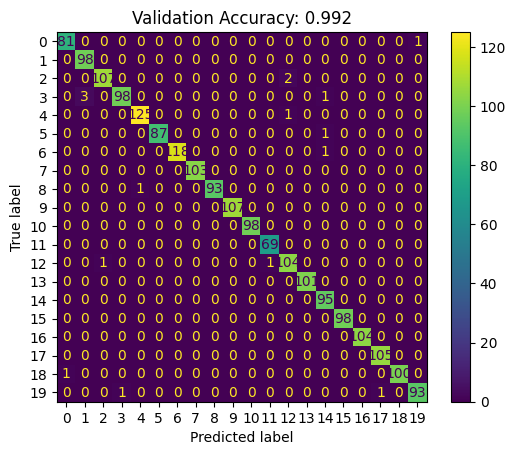

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Recreate model to train from scratch for subtask
model = model_factory()

# Split data indices
n_subset_valid = 2_000
n_subset_train_i = dataset.train_data.shape[0] - n_subset_valid
n_subset_valid_i = n_subset_train_i

# Fit model on all training data except last 2_000 entries
model.fit(dataset.train_data[:n_subset_train_i], dataset.train_labels[:n_subset_train_i])

# Predict on last 2_000 entries
m_cnf = model.conf(dataset.train_data[n_subset_valid_i:], dataset.train_labels[n_subset_valid_i:])

# Transform back to labels instead of probs
f = pt.figure()
a = f.add_subplot()
a.set_title(f'Validation Accuracy: {m_cnf.trace() / m_cnf.sum()}')
ConfusionMatrixDisplay(m_cnf).plot(ax=a)
pt.show()


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/150


2022-11-28 03:12:57.529841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 12ms/step - loss: 1.5526 - categorical_accuracy: 0.4874 - gpu_id: 0/utilization.memory (%): 9.7376 - gpu_id: 0/utilization.gpu (%): 38.5532 - gpu_id: 0/memory.used (MiB): 23145.2247 - gpu_id: 0/memory.free (MiB): 1076.5878 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 2/150
141/141 [==============================] - 1s 9ms/step - loss: 0.6733 - categorical_accuracy: 0.7554 - gpu_id: 0/utilization.memory (%): 16.6383 - gpu_id: 0/utilization.gpu (%): 71.0426 - gpu_id: 0/memory.used (MiB): 23156.9056 - gpu_id: 0/memory.free (MiB): 1064.9069 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 3/150
141/141 [==============================] - 1s 8ms/step - loss: 0.5123 - categorical_accuracy: 0.8168 - gpu_id: 0/utilization.memory (%): 21.3050 - gpu_id: 0/utilization.gpu (%): 76.1064 - gpu_id: 0/memory.used (MiB): 23120.5142 - gpu_id: 0/me

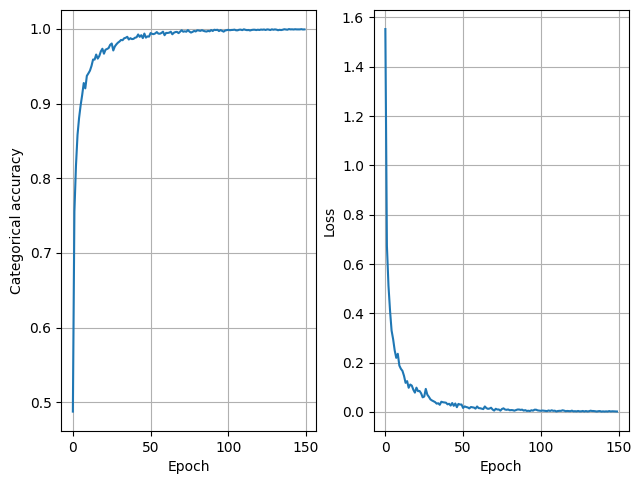

79/79 [==============================] - 0s 1ms/step


In [10]:
# Instantiate model for final prediction on test set
model = model_factory()

# Fit on the entire training to have more data for further predictions
history = model.fit(dataset.train_data, dataset.train_labels)
print(history.accuracy[0])
history.show()

# Predict unknown labels
test_pred_labels = model.predict(dataset.test_data)

In [11]:
# Create resulting test object
test_ids = ps.Series([p.stem for p in sorted(DATASET_TEST_PATH.glob('*.csv'))], name='id')
test_classes = ps.Series(test_pred_labels, name='class')
test_results = ps.DataFrame({
  'id': test_ids,
  'class': test_classes,
})

# And store the results obtained by the model using that previously created test frame
test_results.to_csv(SUBMISSIONS_PATH / 'test_labels_14.csv', mode='w', header=True, index=False)

[autoreload of modules.models failed: Traceback (most recent call last):
  File "/home/invokariman/Documents/projects/git/ub-g11-pml/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/invokariman/Documents/projects/git/ub-g11-pml/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/invokariman/Documents/projects/git/ub-g11-pml/projects/smart/src/modul